# GTC failure classification models and results

In this notebook, we use GTC to classify failure modes.

* Failure classification
    * 7 modes
        * success
        * noscrew
        * no hole found
        * crossthread
        * stripped no engage
        * stripped
        * partial

# Results at a glance
 GTC yields an overall **98.01%** accuracy. 
 It outperforms Random Forest and LSTM models.

The dataset contains a number of fields including
* class.success - 1 sucess, 0 failure
* label.event - beginning and end of a stage
* label.status - 1 when a stage starts, 0 when ends
* scalar 

# Prerequisites

Download and install

* [GTC](http://mathieu.guillame-bert.com/software_repo/gtc_2017_09_10.zip) 
* [Honey](http://framework.mathieu.guillame-bert.com/download_honey#honey)

# Extract labels

Prerequisites

* data files in 

```bash
../raw/label
```

* create directories 

```bash
mkdir -p extracted/label
```

In [3]:
import os
import json

dirPath = "../raw/label/"
label_files = os.listdir(dirPath)
outputFile_csv = "extracted/labels.csv"
outputFile_pred = "extracted/labels.pred"
outputDir_evt = "extracted/label/"

def evt(f,t,s,v=1):
    f.write(str(t)+"\t"+str(s)+"\t"+str(v)+"\n")

#print(label_files)

f_csv = open(outputFile_csv,"w")
f_csv.write("ssts\tresult\tsuccess\n")

f_pred = open(outputFile_pred,"w")

for f in label_files:
    ssts = os.path.splitext(f)[0]

    f_pred.write("Run("+ssts+")\n")
    
    data = json.loads( open(dirPath+f).read() )

    if (data["Result"]=="success"):
        r = "1"
    else:
        r = "0"

    c = -1
    if (data["Result"]=="success"):
        c = 0
    elif (data["Result"]=="noscrew"):
        c = 1
    elif (data["Result"]=="no_hole_found"):
        c = 2
    elif (data["Result"]=="crossthread"):
        c = 3
    elif (data["Result"]=="stripped_no_engage"):
        c = 4
    elif (data["Result"]=="stripped"):
        c = 5
    elif (data["Result"]=="partial"):
        c = 6

    if c==-1:
        print(data["Result"])
        raise "crap with " + data["Result"]

    f_pred.write("Outcome_"+data["Result"]+"("+ssts+")\n")
        
    f_csv.write(ssts + "\t" + data["Result"] + "\t" + r + "\n" )

    f_evt = open(outputDir_evt + ssts + ".evt" ,"w")

    evt(f_evt,0,"class.success",r)
    evt(f_evt,0,"class.type",c)
    
    if data["Result"]=="success":
        evt(f_evt,0,"label:event.success",1)
    else:
        evt(f_evt,0,"label:event.fail",1)

    maxTime = 0
    
    for e in data["timeseries"]:
        label = e["label"]
        interval = e["time"]
        evt(f_evt,interval[0],"label:event.begin_"+label)
        evt(f_evt,interval[1],"label:event.end_"+label)

        evt(f_evt,interval[0],"label:status."+label,1)
        evt(f_evt,interval[1],"label:status."+label,0)

        maxTime = interval[1]

    evt(f_evt,maxTime,"label:event.end_of_annotation")
    
    f_evt.close()
    #break

f_csv.close()
f_pred.close()
print("done")

done


# Extract features

TODO
to reproduce

Run the honey scripts. Haven't tried.
```bash
honey feature_ft_v2.hny
honey feature_motor_v2.hny
```

The results are

/data/foxconn/foxconn/screwdriving_data/old/processed/

* ft_v2/*.bin - force and torque in x, y and z
* motor_v2/*.bin - current and angle

### feature_ft_v2.hny

In [51]:
%%bash

cat feature_ft_v2.hny

@data input:"raw/ft" output:"processed/ft_v2" extension:"bin"
#@data input:"raw/ft/sd_0_0_1456794424.csv" output:"processed/ft/sd_0_0_1456794424.bin"

$all = echo #.*

$mf = movingFeatures $all 0.1 output:mean,sd,range
$mf += movingFeatures $all 0.2 output:mean,sd,range
$mf += movingFeatures $all 0.3 output:mean,sd,range

$peaks += peak $all 0.5
$peaks += peak $mf 0.5
$peaks += peak $all 0.3
$peaks += peak $mf 0.3

$mf = skip $mf 0.02 noTail:true
$all = skip $all 0.01 noTail:true

$output = echo $all
$output += echo $mf
$output += echo $peaks

saveBufferedBin $output file:%output





###  feature_motor_v2.hny

In [52]:
%%bash

cat feature_motor_v2.hny

@data input:"raw/motor" output:"processed/motor_v2" extension:"bin"
#@data input:"raw/motor/sd_0_0_1456794424.csv" output:"processed/motor/sd_0_0_1456794424.bin"

$all = echo #.*

$mf = movingFeatures $all 0.1 output:mean,sd,range
$mf += movingFeatures $all 0.2 output:mean,sd,range
$mf += movingFeatures $all 0.3 output:mean,sd,range

$peaks += peak $all 0.5
$peaks += peak $mf 0.5
$peaks += peak $all 0.3
$peaks += peak $mf 0.3

$output = echo $all
$output += echo $mf
$output += echo $peaks

saveBufferedBin $output file:%output





In [19]:
%%bash

cat extractSnapshop_lastRecord.hny

@data input:"/data/foxconn/foxconn/screwdriving_data/old/processed/motor;/data/foxconn/foxconn/screwdriving_data/old/processed/ft;/data/foxconn/foxconn/screwdriving_data/run19x/extracted/label" output:"snapshot/endofrecord" extension:"bin"

$all = echo #.*

$limit = filter $all "label:event\.end_of_annotation"
$limit = delay $limit 0.001

#$all = passIf $all "arg1,0.5,<" arg1:$limit
$all = passIfState $all gate:$limit reverse:true

$output = echo $all

saveBufferedBin $output file:%output


In [21]:
%%bash

# mkdir -p snapshot/endofrecord

honey extractSnapshop_lastRecord.hny

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


The command creates an SSTS file in binary format. Each file comprises 137 channels.

# Merge CSVs to a bin file

In [22]:
%%bash

head merged_featurized.sevt

offset 200

sequence 0
dataset snapshot/endofrecord/sd_0_0_1456794424.bin
flush

sequence 1
dataset snapshot/endofrecord/sd_0_0_1456798449.bin
flush



In [10]:
%%bash

cat merged_featurized.hny

@data input:merged_featurized.sevt output:"merged_featurized.bin"

$ALL = echo "#.*"
$SEQUENCE = filter $ALL "sequence"

$BEGIN = eq $SEQUENCE =1
$BEGIN = rename $BEGIN begin
$OUTPUT += echo $BEGIN

$OUTPUT += echo $ALL
saveBufferedBin $OUTPUT file:%output


In [23]:
%%time
%%bash

honey merged_featurized.hny | tail

	Building input dataset...done
	Input event instances: 40892181
	Input event symbols: 158
	Applying operation...
	Output event instances: 0 (0%)
	Output event symbols: 0 (0%)
	Duration: 8s
* Remove the cache for 3 operations. 0 cache(s) remaining.
	Static processing done
done
CPU times: user 1.98 ms, sys: 4.14 ms, total: 6.11 ms
Wall time: 12.6 s


# Failure classification

Classify an observation of time sequences to one of 7 classes.

## Train a GTC-DF model

* 10 fold cross validation

### GTC configuration file

In [30]:
%%bash

cat config_gtc.xml

<!--
The file that contains the configuration parameters for the learning.
-->

<config>

<option name="saveRules_new" value="details/motives.xml" />

<!--
<data path="featurized.sevt" head="" limit="-1" />
-->
<data path="merged_featurized.bin" head="" limit="-1" />

<option name="threads" value="8" /> 

<option name="debugLevel" value="1" />  <!-- Level of verbose of the algorithm -->

<option name="numCaseHead" value="60" />  <!-- maximum values to consider in the split -->
<option name="maxPastHead" value="-5" />  <!-- Bounds of the histogram -->
<option name="maxFutureHead" value="5" />  <!-- Bounds of the histogram -->

<option name="negation" value="1" />
<option name="maxConditions" value="6" /> <!-- max depth 6 -->

<option name="maxLoop" value="300" /> <!-- # of boostrap 120 -->

<option name="maxRoots" value="5" /> <!-- # of boostrap 40 -->

<option name="realNegation" value="1" />

<option name="minNumberOfUse" value="5" />


<option name="symbolSampling" value="1" />

<!--

### Command to train GTC

In [27]:
%%bash

cat learnClassifierGTC.sh

GTC_HOME=/home/dwang/sandbox/gtc_2017_09_10/gtc/bin
${GTC_HOME}/gtc crossValidationMotives --config config_gtc.xml \
    --outputPlot 0 \
    --output results/cv.csv --folds 10


### Train GTC 

In [28]:
%%time
%%bash

bash learnClassifierGTC.sh | tail


Save results
	ROC
	predictions
	details
	attr importance
	motive importance
	evaluation
	stats
	info
CPU times: user 19.4 ms, sys: 9.11 ms, total: 28.5 ms
Wall time: 12min 47s


### Results

In [29]:
%%bash

cat ./results/cv.info

sequences	1862
duration_text	12mn 43s
duration	763.259
training_time_text	12mn 23s
training_time	743.329
testing_time_text	9.5s
testing_time	9.52352
folds	10
classes	7
R2	-nan
Correlation	-nan
RSME	-nan
MAE	nan
accuracy	0.980129
error	0.0198711
motives	105226
voteMerging	TOP
individualVoteMerging	DIST
config	config_gtc.xml
date	22-01-2018_13-37-32
sparceData	0
dataset	merged_featurized.bin


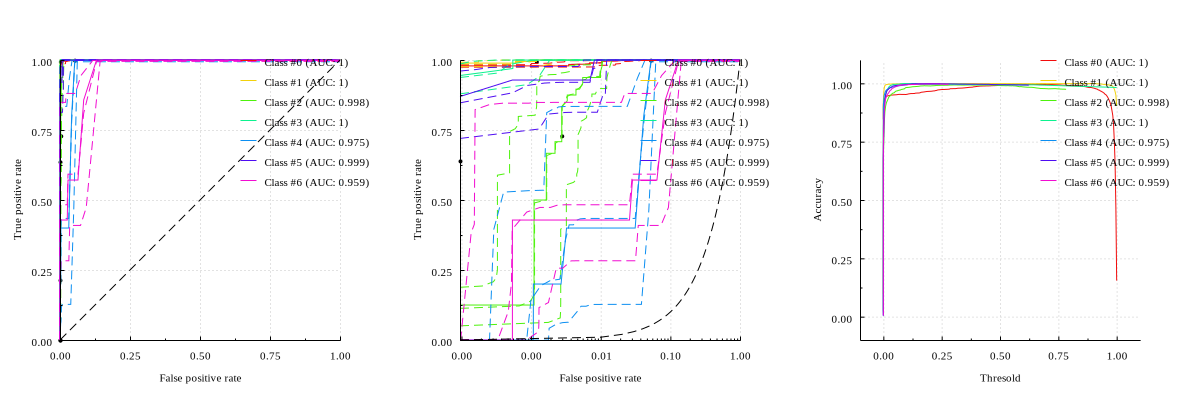

In [50]:
from IPython.display import SVG
SVG(filename='results/cv_roc.svg')

### Evaluation

In [39]:
import pandas as pd
df = pd.read_csv('results/cv.csv', sep='\t')
df.head()

,sequence,truth,prediction,fold,p0,p1,p2,p3,p4,p5,p6
0,1204,0,0,0,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1,1213,0,0,0,0.996667,0.0,0.003333,0.000000,0.0,0.000000,0.000000
2,1575,0,0,0,0.986667,0.0,0.003333,0.000000,0.0,0.000000,0.010000
3,352,0,0,0,0.993333,0.0,0.000000,0.003333,0.0,0.000000,0.003333
4,66,0,0,0,0.996667,0.0,0.000000,0.000000,0.0,0.003333,0.000000


In [48]:
from sklearn.metrics import classification_report,confusion_matrix
y_true=df['truth'].tolist()
y_pred=df['prediction'].tolist()
target_names = ['success', 'noscrew', 'no hole found', 'crossthread',
        'stripped no engage',
        'stripped',
        'partial']

#### Confusion Matrix

In [47]:
confusion_matrix(y_true,y_pred)

array([[1573,    1,    0,    0,    0,    0,    0],
       [   0,  181,    0,    0,    0,    0,    0],
       [   4,    1,   43,    0,    0,    0,    0],
       [   7,    1,    2,   23,    0,    0,    0],
       [   0,    0,    5,    0,    0,    0,    0],
       [   8,    0,    1,    0,    0,    5,    0],
       [   6,    0,    1,    0,    0,    0,    0]])

#### Classification report

In [49]:
print(classification_report(y_true, y_pred, target_names=target_names))

                    precision    recall  f1-score   support

           success       0.98      1.00      0.99      1574
           noscrew       0.98      1.00      0.99       181
     no hole found       0.83      0.90      0.86        48
       crossthread       1.00      0.70      0.82        33
stripped no engage       0.00      0.00      0.00         5
          stripped       1.00      0.36      0.53        14
           partial       0.00      0.00      0.00         7

       avg / total       0.97      0.98      0.98      1862



/data/apps/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
